In [ ]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='5727259e-8066-4fda-811e-6c7dd767a11f', project_access_token='p-b858d9bc6d70d9f87e8e541ef25a442c8e6df39f')
pc = project.project_context


In [16]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.models import load_model
# from nltk.corpus import stopwords
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
#import chart_studio.plotly as py
# import cufflinks
# from IPython.core.interactiveshell import InteractiveShell
# import plotly.figure_factory as ff
# InteractiveShell.ast_node_interactivity = 'all'
# from plotly.offline import iplot
# cufflinks.go_offline()
# cufflinks.set_config_file(world_readable=True, theme='pearl')

In [19]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_d5f7a9e358de4458b1bb036e3bc7168b = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='dJ4uBfTeMo5MxhnurKoMi-fA9aQVfVS8a1d18WB6yFSh',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_d5f7a9e358de4458b1bb036e3bc7168b.get_object(Bucket='servicenowoptimization-donotdelete-pr-aorznkbrgxpb8j',Key='servicenow5.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()


,Unnamed: 0,active,activity_due,additional_assignee_list,approval,approval_history,approval_set,assigned_to,assignment_group,business_duration,...,universal_request,upon_approval,upon_reject,urgency,user_input,watch_list,work_end,work_notes,work_notes_list,work_start
0,0,False,12/13/2016 1:26,NaN,not requested,NaN,NaN,{'link': 'https://<instance_name>.service-now....,{'link': 'https://<instance_name>.service-now....,1/1/1970 8:00,...,NaN,proceed,cancel,2,NaN,NaN,NaN,NaN,NaN,NaN
1,1,False,NaN,NaN,not requested,NaN,NaN,NaN,NaN,1/1/1970 0:00,...,NaN,proceed,cancel,2,NaN,NaN,NaN,NaN,NaN,NaN
2,2,False,NaN,NaN,not requested,NaN,NaN,{'link': 'https://<instance_name>.service-now....,{'link': 'https://<instance_name>.service-now....,1/21/1970 6:05,...,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
3,3,False,NaN,NaN,not requested,NaN,NaN,{'link': 'https://<instance_name>.service-now....,{'link': 'https://<instance_name>.service-now....,1/22/1970 14:03,...,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN
4,4,False,NaN,NaN,not requested,NaN,NaN,{'link': 'https://<instance_name>.service-now....,{'link': 'https://<instance_name>.service-now....,1/20/1970 21:55,...,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
#df = pd.read_csv("F:\\Hackathon\\servicenow5.csv")

df['text'] = df['description'] + df['short_description']

In [22]:
df[["u_portfolio","opened_at","business_service","short_description","description"]].describe()

,u_portfolio,opened_at,business_service,short_description,description
count,63,63,1,63,63
unique,5,59,1,62,63
top,IBM IT Helpdesk,8/7/2020 20:48,{'link': 'https://<instance_name>.service-now....,Reset my password,Hard drive is still making grinding and clicki...
freq,32,3,1,2,1


In [23]:
df[["u_portfolio","opened_at","business_service","short_description","description"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 5 columns):
u_portfolio          63 non-null object
opened_at            63 non-null object
business_service     1 non-null object
short_description    63 non-null object
description          63 non-null object
dtypes: object(5)
memory usage: 2.5+ KB


In [24]:
df.u_portfolio.value_counts()

IBM IT Helpdesk           32
PRODUCT Development       16
IBM INFRA Helpdesk        11
IBM PAYROLL Helpdesk       2
IBM Operation Helpdesk     2
Name: u_portfolio, dtype: int64

Categories: 5


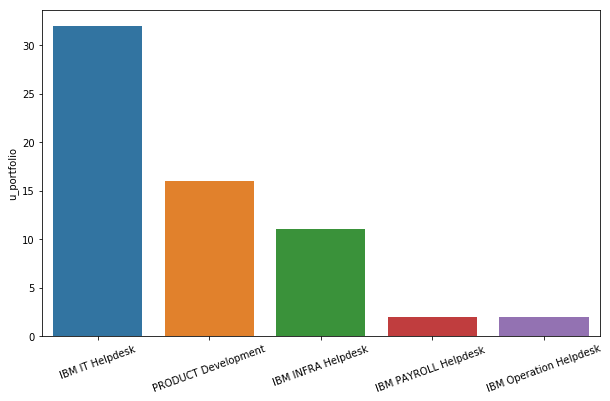

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
# Eliminate categories with fewer than 100 tickets
classifier = "u_portfolio"
ticket_threshold = 100
df_classifiers = df[df.groupby(classifier)[classifier].transform(len) > 0]
# Print number of relevant categories & shape
print("Categories: " + str(df_classifiers[classifier].nunique()))
# # Plot the classifiers
fig = plt.figure(figsize=(10,6))
sns.barplot(df_classifiers[classifier].value_counts().index, df_classifiers[classifier].value_counts())
plt.xticks(rotation=20)
plt.show()

In [26]:
def print_plot(index):
    example = df[df.index == index][['text', 'u_portfolio']].values[0]
    if len(example) > 0:
        print(example[0])
        print('PortFolio:', example[1])
print_plot(62)

Need access to the common drive for sharing files which can be accessed by all members. Please provide access.Need access to the common drive.
PortFolio: PRODUCT Development


In [28]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].str.replace('\d+', '')

In [29]:
print_plot(10)

hard drive making loud grinding noise last two daysseem issue hard drive
PortFolio: IBM INFRA Helpdesk


In [30]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 432 unique tokens.


In [31]:
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (63, 250)


In [32]:
Y = pd.get_dummies(df['u_portfolio']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (63, 5)


In [33]:
Y

array([[0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0,

In [34]:
A = pd.DataFrame(df['u_portfolio'])

In [35]:
A['u_portfolio'].value_counts()

IBM IT Helpdesk           32
PRODUCT Development       16
IBM INFRA Helpdesk        11
IBM PAYROLL Helpdesk       2
IBM Operation Helpdesk     2
Name: u_portfolio, dtype: int64

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(25, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



epochs = 10
batch_size = 15

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

print(history)

(44, 250) (44, 5)
(19, 250) (19, 5)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 39 samples, validate on 5 samples
Epoch 1/10
39/39 [==============================] - 13s 343ms/step - loss: 1.6087 - acc: 0.1795 - val_loss: 1.6125 - val_acc: 0.2000
Epoch 2/10
39/39 [==============================] - 5s 129ms/step - loss: 1.5833 - acc: 0.5385 - val_loss: 1.6025 - val_acc: 0.2000
Epoch 3/10
39/39 [==============================] - 9s 229ms/step - loss: 1.5635 - acc: 0.6923 - val_loss: 1.5917 - val_acc: 0.2000
Epoch 4/10
39/39 [==============================] - 5s 130ms/step - loss: 1.5388 - acc: 0.7436 - val_loss: 1.5787 - val_acc: 0.4000
Epoch 5/10
39/39 [==============================] - 9s 227ms/step - loss: 1.5135 - acc: 0.7949 - val_loss: 1.5633 - val_acc: 0.4000
Epoch 6/10
39/39 [=======

In [37]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))


19/19 [==============================] - 0s 3ms/step
Test set
  Loss: 1.263
  Accuracy: 0.632


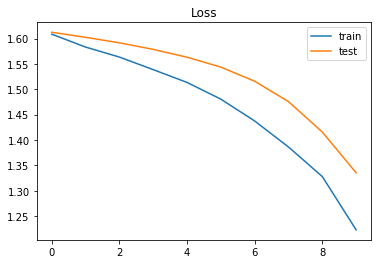

In [38]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();


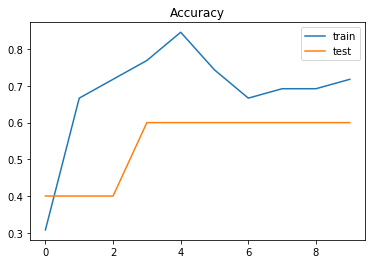

In [20]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();


In [40]:
new_complaint = ['Facing issues with SAP UI']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['IBM INFRA Helpdesk','IBM IT Helpdesk', 'IBM Operation Helpdesk', 'IBM PAYROLL Helpdesk', 'PRODUCT Development']
print(pred, labels[np.argmax(pred)])

[[0.14390087 0.3985864  0.11165278 0.11747944 0.22838043]] IBM IT Helpdesk


In [41]:
df.u_portfolio.value_counts()

IBM IT Helpdesk           32
PRODUCT Development       16
IBM INFRA Helpdesk        11
IBM PAYROLL Helpdesk       2
IBM Operation Helpdesk     2
Name: u_portfolio, dtype: int64

In [23]:
pred

array([[0.17336534, 0.42993852, 0.04501655, 0.05140622, 0.3002734 ]],
      dtype=float32)

In [2]:
# import nltk
# nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dsxuser/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
# !pip install cufflinks

     |████████████████████████████████| 81kB 6.0MB/s eta 0:00:011
     |████████████████████████████████| 12.9MB 11.8MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/7d/ba/8d/38b672c3e40d8bd22dd60b8e6e29965b43f2b4be4d064e44d5
Successfully built cufflinks
  Found existing installation: plotly 3.6.1
    Uninstalling plotly-3.6.1:
      Successfully uninstalled plotly-3.6.1
